In [5]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42

import json
import numpy as np
from color import get_color, get_colors
import matplotlib.pyplot as plt

In [7]:
%load_ext autoreload
%autoreload 2
from retrieve import retrieve_planner_stats_by_run, retrieve_planner_stats_by_steering
from definitions import *
from utils import *
from mpb import MPB, MultipleMPB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Stats by Steer Function

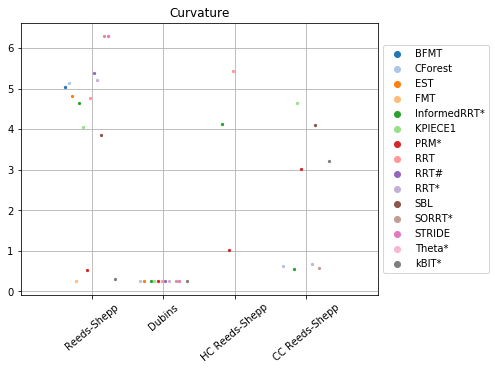

In [42]:
%reload_ext autoreload
scenario = '../results/warehouse.json'
metric = 'curvature'
steer_funcs = [
    'reeds_shepp',
    'dubins',
#     'posq',
#     'clothoid',
#     'linear',
#     'cc_dubins',
    'hc_reeds_shepp',
    'cc_reeds_shepp'
]
ignored_planners = [
    'SBPL', 'SST'
]
expected_number_of_planners = 15
found_planners = []
stats_by_steering = retrieve_planner_stats_by_steering(scenario, steer_funcs=','.join(steer_funcs))
sf_counter = 0
plt.figure(figsize=(8, 5))
for si, (sf, steering) in enumerate(stats_by_steering.items()):
    for planner, stats in steering.items():
        if planner in ignored_planners:
            continue
        if planner not in found_planners:
            found_planners.append(planner)
        pi = found_planners.index(planner)
        values = [v[metric] for v in stats.values() if v["exact_goal_path"]]
        xs = np.ones(len(values)) * (0.5 + sf_counter + (pi - expected_number_of_planners / 2) / 20)
        if sf_counter == 0:
            plt.scatter([], [], color=get_color(pi, num_colors=20), label=convert_planner_name(planner))
        plt.scatter(xs, values, color=get_color(pi, num_colors=20), s=5)
    sf_counter += 1

xs = 0.5 + np.arange(len(steer_funcs))
xlabels = [steer_function_names[s] for s in steer_funcs]
plt.xticks(xs, xlabels, rotation=40)
plt.gca().set_axisbelow(True)
plt.grid()
plt.gca().set_xlim([-0.5, len(steer_funcs) + 0.5])
plt.title(stat_names[metric]);

# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('curvature_warehouse.png', dpi=300, bbox_inches='tight')

## Stats over different runs with one steer function

In [59]:
%reload_ext autoreload
scenario_parameters = [2, 3, 4, 5, 6]
scenarios = ['../results/turning_radius%i.000000' % v for v in scenario_parameters]
metric = 'curvature'
steer_func = 'reeds_shepp'
ignored_planners = [
    'SBPL', 'SST'
]
expected_number_of_planners = 15
found_planners = []
plt.figure(figsize=(8, 5))

ys = {}

for si, (scenario_parameter, scenario) in enumerate(zip(scenario_parameters, scenarios)):
    stats_by_steering = retrieve_planner_stats_by_steering(scenario, steer_funcs=steer_func)
    steering = list(stats_by_steering.values())[0]
#     print(steering)
    for planner, stats in steering.items():
        if planner in ignored_planners:
            continue
        if planner not in found_planners:
            ys[planner] = {}
            found_planners.append(planner)
        if scenario_parameter not in ys[planner]:
            ys[planner][scenario_parameter] = []
        ys[planner][scenario_parameter] += [v[metric] for v in stats.values() if v["exact_goal_path"]]

plt.gca().set_axisbelow(True)
plt.grid()

print(found_planners)

def clean_mean(vs):
    if None in vs:
        return None
    return np.mean(vs)
# print(ys)

means = []
stds = []
for pi, planner in enumerate(found_planners):
#     print(ys[planner])
    means = [clean_mean(vs) for vs in ys[planner].values()]
    plt.plot(scenario_parameters, means, '*-', color=get_color(pi, num_colors=20), label=convert_planner_name(planner))
# plt.gca().set_xlim([-0.5, len(steer_funcs) + 0.5])
plt.title(stat_names[metric]);

# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_xlabel('Turning Radius')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('turning_radii_%s.png' % metric, dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '../results/turning_radius2.000000'

<Figure size 576x360 with 0 Axes>

['BFMT', 'EST', 'InformedRRTstar', 'KPIECE1', 'RRT', 'RRTstar', 'SBPL_ADstar', 'Theta*', 'kBITstar']


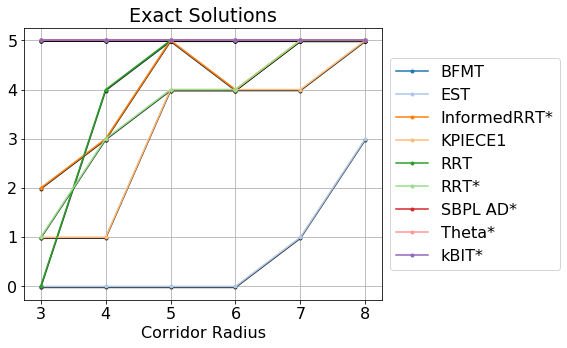

In [56]:
%reload_ext autoreload
scenario_parameters = [3, 4, 5, 6, 7, 8]
scenarios = ['../bin/log/corridor_radius_%i.json' % v for v in scenario_parameters]
metric = 'exact_solutions'
steer_func = 'cc_reeds_shepp'
ignored_planners = [
#     'SBPL', 'SST'
]
expected_number_of_planners = 15
found_planners = []

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(8, 5))

ys = {}

for si, (scenario_parameter, scenario) in enumerate(zip(scenario_parameters, scenarios)):
    stats_by_steering = retrieve_planner_stats_by_steering(scenario, steer_funcs=steer_func)
    steering = list(stats_by_steering.values())[0]
#     print(steering)
    for planner, stats in steering.items():
        if planner in ignored_planners:
            continue
        if planner not in found_planners:
            ys[planner] = {}
            found_planners.append(planner)
        if scenario_parameter not in ys[planner]:
            ys[planner][scenario_parameter] = []
        if metric == "cusps":
            ys[planner][scenario_parameter] += [len(v[metric]) for v in stats.values() if v["exact_goal_path"]]
        elif metric == "exact_solutions":
            ys[planner][scenario_parameter] += [sum([1 for v in stats.values() if v["exact_goal_path"]])]
        else:
            ys[planner][scenario_parameter] += [v[metric] for v in stats.values() if v["exact_goal_path"]]

plt.gca().set_axisbelow(True)
plt.grid()

print(found_planners)

def clean_mean(vs):
    if None in vs:
        return np.nan
    return np.mean(vs)

def clean_std(vs):
    if None in vs:
        return np.nan
    return np.std(vs)
# print(ys)

means = []
stds = []
for pi, planner in enumerate(found_planners):
    means = np.array([clean_mean(vs) for vs in ys[planner].values()])
    stds = np.array([clean_std(vs) for vs in ys[planner].values()])
    plt.fill_between(scenario_parameters, means-stds, means+stds, alpha=0.2, color=get_color(pi, num_colors=20), zorder=2)
    # add some shadow below the plot
    plt.plot(scenario_parameters, means - 0.02, '.-', color=(0, 0, 0, .8), zorder=3)
    plt.plot(scenario_parameters, means, '.-', color=get_color(pi, num_colors=20), label=convert_planner_name(planner), zorder=4)
# plt.gca().set_xlim([-0.5, len(steer_funcs) + 0.5])
if metric in stat_names:
    plt.title(stat_names[metric]);
else:
    plt.title(metric)

# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_xlabel('Corridor Radius')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('corridor_radii_%s.png' % metric, dpi=300, bbox_inches='tight')
plt.savefig('corridor_radii_%s.pdf' % metric, dpi=300, bbox_inches='tight')

Available memory: 256.55 GB, limiting each MPB process to 6.9% usage (17.82 GB).
Creating pool of 6 processes.
Created MPB from config radii_reeds_shepp/radii_reeds_shepp_0_config.json.
Created MPB from config radii_reeds_shepp/radii_reeds_shepp_3_config.json.
Created MPB from config radii_reeds_shepp/radii_reeds_shepp_1_config.json.
Created MPB from config radii_reeds_shepp/radii_reeds_shepp_5_config.json.
Created MPB from config radii_reeds_shepp/radii_reeds_shepp_2_config.json.
Created MPB from config radii_reeds_shepp/radii_reeds_shepp_4_config.json.
Running MPB with ID radii_reeds_shepp_0 (log file at radii_reeds_shepp/radii_reeds_shepp_0.log)...
Running MPB with ID radii_reeds_shepp_3 (log file at radii_reeds_shepp/radii_reeds_shepp_3.log)...
Running MPB with ID radii_reeds_shepp_4 (log file at radii_reeds_shepp/radii_reeds_shepp_4.log)...
Running MPB with ID radii_reeds_shepp_2 (log file at radii_reeds_shepp/radii_reeds_shepp_2.log)...
Running MPB with ID radii_reeds_shepp_1 (lo

Killed radii_reeds_shepp_5 with planner sorrt_star after 300.02s exceeded timeout.
Killed radii_reeds_shepp_4 with planner sorrt_star after 300.01s exceeded timeout.

Benchmark 5 (radii_reeds_shepp_5) finished successfully.

Benchmark 0 (radii_reeds_shepp_0) finished successfully.

Benchmark 4 (radii_reeds_shepp_4) finished successfully.

Benchmark 1 (radii_reeds_shepp_1) finished successfully.

Benchmark 2 (radii_reeds_shepp_2) finished successfully.

Benchmark 3 (radii_reeds_shepp_3) finished successfully.
All benchmarks succeeded.


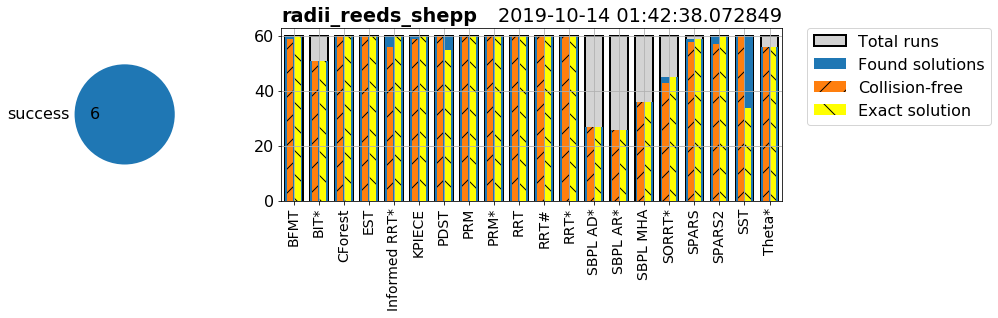

In [19]:
radii = [3, 4, 5, 6, 7, 8]
steer_function = 'reeds_shepp'
    
pool = MultipleMPB()
# config = MPB.get_config()
for radius in radii:
    m = MPB()   
    # m.update(deepcopy(config))
    m.set_corridor_grid_env(100, 100, branches=100, radius=radius)
#     m["max_planning_time"] = 0.1
#     m["env.start"] = start
#     m["env.goal"] = goal
#     m["env.type"] = "polygon"
#     m["interpolation_limit"] = 10
#     m["env.polygon.source"] = "polygon_mazes/%s.svg" % scenario
#     if robot_model:
#         print("Using robot model %s." % robot_model)
#         m["env.collision.robot_shape_source"] = robot_model
    #         m["benchmark.planning.sbpl_adstar"] = False
    #         m["benchmark.planning.sbpl_anastar"] = False
    #         m["benchmark.planning.sbpl_arastar"] = False
    #         m["benchmark.planning.sbpl_lazy_ara"] = False
    #         m["benchmark.planning.sbpl_mha"] = False
    m.set_steer_functions([steer_function])
    #     m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
#     m.set_planners(all_planners)
    #     m.set_planners(['sbpl_adstar'])
    pool.benchmarks.append(m)
run_result = pool.run_parallel("radii_" + steer_function, runs=10, processes=40, limit_memory=True)

/root/code/mpb/plotting/trajectory.py:73: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


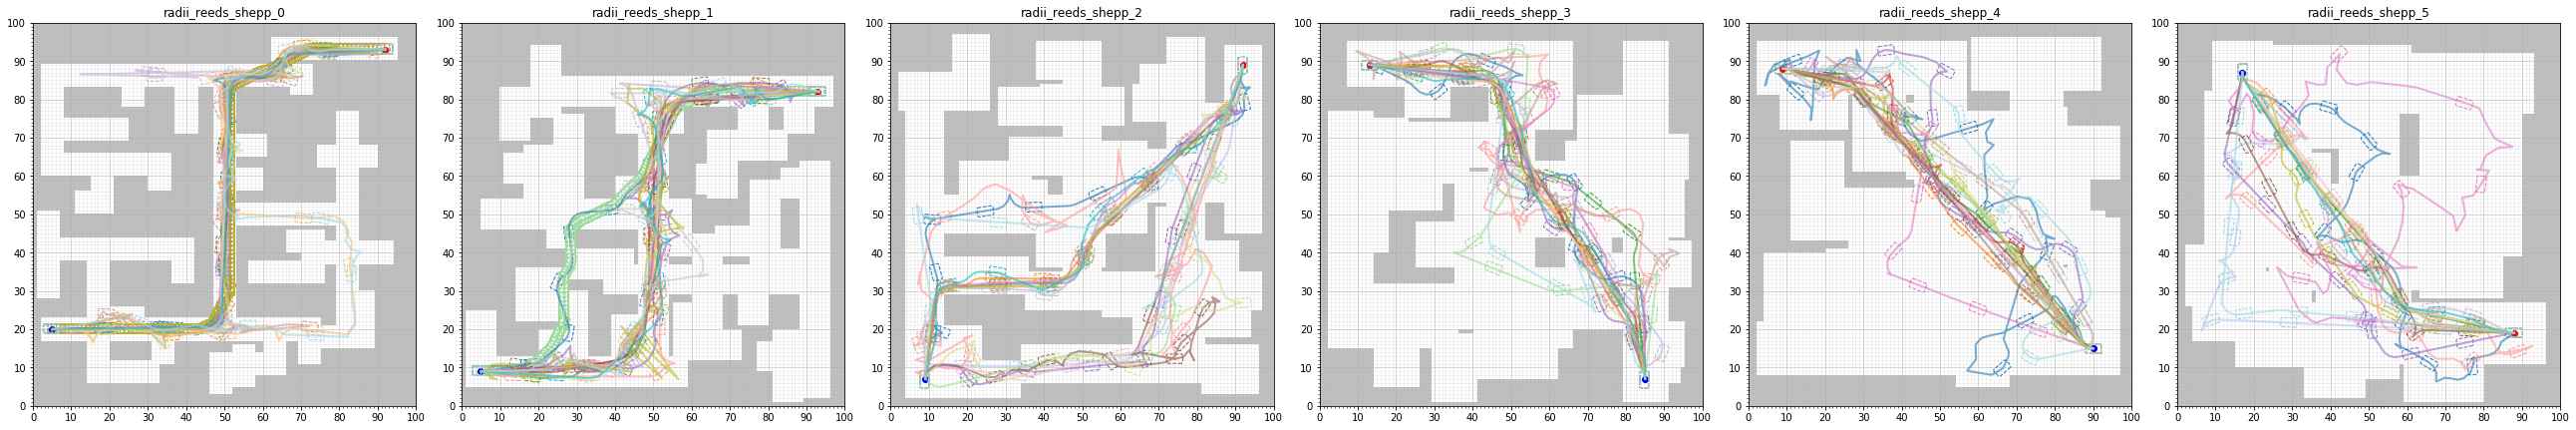

In [9]:
pool.visualize_trajectories()

['RRT#', 'RRTstar', 'SPARS', 'PDST', 'SBPL_ARstar', 'kBITstar', 'Theta*', 'KPIECE1', 'SORRTstar', 'PRMstar', 'CForest', 'InformedRRTstar', 'PRM', 'BFMT', 'SPARStwo', 'EST', 'RRT', 'SBPL_MHA', 'SBPL_ADstar']


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


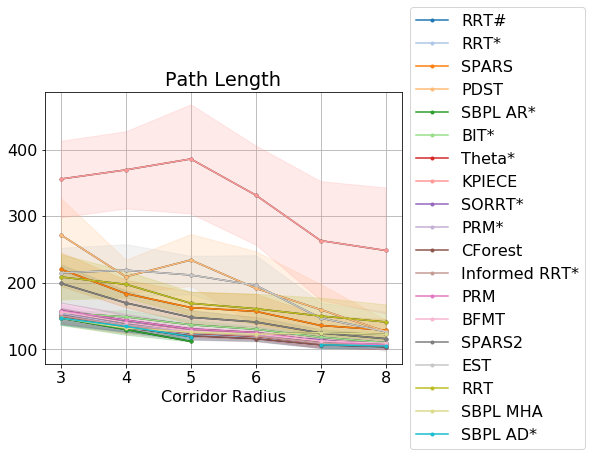

In [21]:
%reload_ext autoreload

metric = 'path_length'#'exact_solutions'
scenario_parameters = radii

ignored_planners = [
    'SBPL', 'SST'
]

expected_number_of_planners = 15
found_planners = []

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(8, 5))

ys = {}

for i, scenario_parameter in enumerate(scenario_parameters):
    scenario = "radii_%s/radii_%s_%i_results.json" % (steer_function, steer_function, i)
    stats_by_steering = retrieve_planner_stats_by_steering(scenario, steer_funcs=steer_function)
    steering = list(stats_by_steering.values())[0]
#     print(steering)
    for planner, stats in steering.items():
        if planner in ignored_planners:
            continue
        if planner not in found_planners:
            ys[planner] = {}
            found_planners.append(planner)
        if scenario_parameter not in ys[planner]:
            ys[planner][scenario_parameter] = []
        if metric == "cusps":
            ys[planner][scenario_parameter] += [len(v[metric]) for v in stats.values() if v["exact_goal_path"]]
        elif metric == "exact_solutions":
            ys[planner][scenario_parameter] += [sum([1 for v in stats.values() if v["exact_goal_path"]])]
        else:
            ys[planner][scenario_parameter] += [v[metric] for v in stats.values() if v["exact_goal_path"]]

plt.gca().set_axisbelow(True)
plt.grid()

print(found_planners)

means = []
stds = []
for pi, planner in enumerate(found_planners):
    means = np.array([safe_mean(vs) for vs in ys[planner].values()])
    stds = np.array([safe_std(vs) for vs in ys[planner].values()])
    plt.fill_between(scenario_parameters, means-stds, means+stds, alpha=0.2, color=get_color(pi, num_colors=20), zorder=2)
    # add some shadow below the plot
    plt.plot(scenario_parameters, means - 0.02, '.-', color=(0, 0, 0, .8), zorder=3)
    plt.plot(scenario_parameters, means, '.-', color=get_color(pi, num_colors=20), label=convert_planner_name(planner), zorder=4)
# plt.gca().set_xlim([-0.5, len(steer_funcs) + 0.5])
if metric in stat_names:
    plt.title(stat_names[metric]);
else:
    plt.title(metric)

# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_xlabel('Corridor Radius')

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('corridor_radii_%s.png' % metric, dpi=300, bbox_inches='tight')
plt.savefig('corridor_radii_%s.pdf' % metric, dpi=300, bbox_inches='tight')